In [66]:
___Author___='LumberJack Jyss'

In [67]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [68]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [69]:
import warnings
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [70]:
df_1D = pd.read_csv('20190526 data prepared.csv')
df_1D = df_1D.iloc[:,1:]
df_1D = df_1D.dropna()
df_1D.reset_index(inplace=True,drop=True)

In [71]:
df_1D.isnull().sum().sum()

0

In [72]:
df_1D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 28 columns):
Date                  1207 non-null int64
Vix                   1207 non-null float64
P/C Ratio             1207 non-null float64
Varop_Spy             1207 non-null float64
Varhl_spy             1207 non-null float64
Varop_vix             1207 non-null float64
Varhl_vix             1207 non-null float64
RSI                   1207 non-null float64
75 - RSI              1207 non-null float64
RSI - 25              1207 non-null float64
BBD_Delta_Up          1207 non-null float64
delta5_8              1207 non-null float64
delta8_10             1207 non-null float64
delta10_12            1207 non-null float64
delta12_15            1207 non-null float64
delta15_30            1207 non-null float64
delta30_35            1207 non-null float64
delta35_40            1207 non-null float64
delta40_45            1207 non-null float64
delta45_50            1207 non-null float64
Spread         

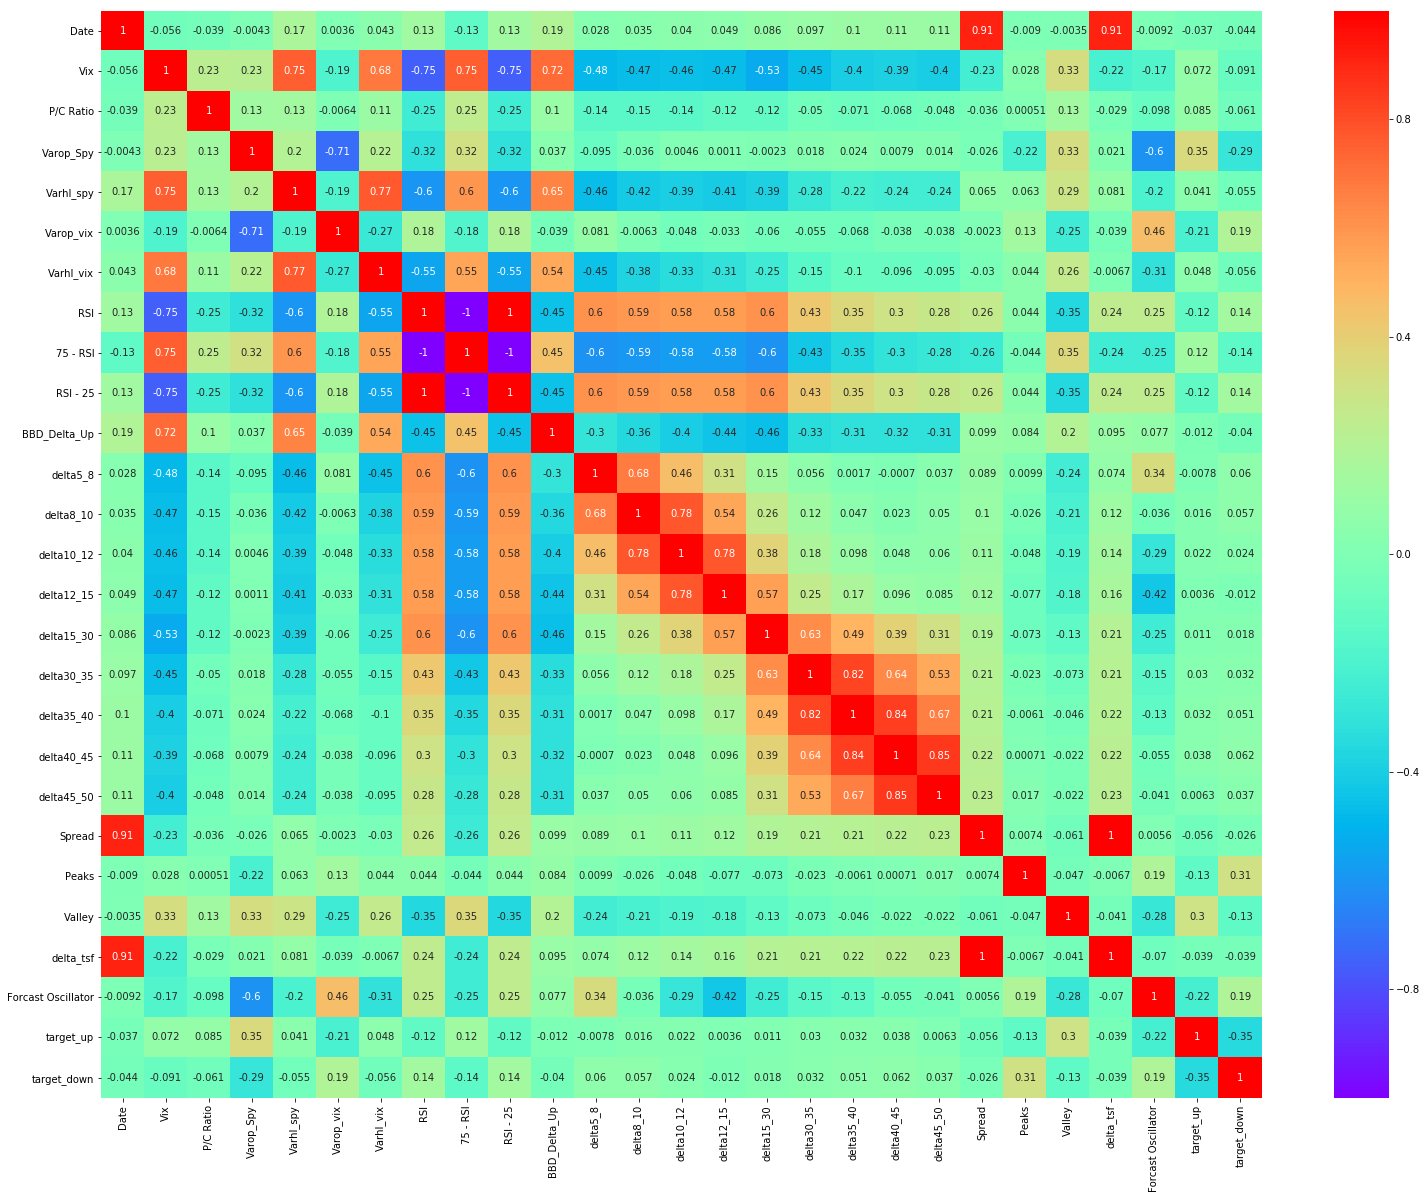

In [73]:
plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [74]:
df_1D.shape

(1207, 28)

In [75]:
df_1D['target_up'].sum(),df_1D['target_down'].sum()

(314, 311)

In [76]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  1207
On 80% - 20% slash : 
Bloc 1 :  966  periods ( 20180612 )
Bloc 2 : 241  periods ( 20150727 )
First period : 20140811
Last period : 20190528


In [77]:
X = df_1D.iloc[:,1:-4]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values

In [78]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 23 columns):
Vix             1207 non-null float64
P/C Ratio       1207 non-null float64
Varop_Spy       1207 non-null float64
Varhl_spy       1207 non-null float64
Varop_vix       1207 non-null float64
Varhl_vix       1207 non-null float64
RSI             1207 non-null float64
75 - RSI        1207 non-null float64
RSI - 25        1207 non-null float64
BBD_Delta_Up    1207 non-null float64
delta5_8        1207 non-null float64
delta8_10       1207 non-null float64
delta10_12      1207 non-null float64
delta12_15      1207 non-null float64
delta15_30      1207 non-null float64
delta30_35      1207 non-null float64
delta35_40      1207 non-null float64
delta40_45      1207 non-null float64
delta45_50      1207 non-null float64
Spread          1207 non-null float64
Peaks           1207 non-null int64
Valley          1207 non-null int64
delta_tsf       1207 non-null float64
dtypes: float64(21), in

In [79]:
X.iloc[:5,[6,7]]

,RSI,75 - RSI
0,45.146656,29.853344
1,44.065975,30.934025
2,49.402586,25.597414
3,52.580633,22.419367
4,52.530232,22.469768


In [80]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [81]:
X[:5,[6,7]]

array([[0.40589373, 0.59410627],
       [0.39043778, 0.60956222],
       [0.46676223, 0.53323777],
       [0.51221479, 0.48778521],
       [0.51149396, 0.48850604]])

In [82]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [83]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((966, 23), (966, 1), (966, 1), (241, 1), (241, 1))

In [84]:
model_up = XGBClassifier(silent=False,objective='binary:logistic',n_estimators=800,booster='gbtree')
eval_set_up = [(Xtrain, ytrain_up), (Xtest, ytest_up)]
history_up = model_up.fit( Xtrain, ytrain_up, eval_metric=['auc','error'], eval_set=eval_set_up, verbose=0)

In [85]:
model_down = XGBClassifier(silent=False,objective='binary:logistic',n_estimators=800)
eval_set_down = [(Xtrain, ytrain_down), (Xtest, ytest_down)]
history_down = model_down.fit( Xtrain, ytrain_down, eval_metric=['auc','error'], eval_set=eval_set_down, verbose=0)

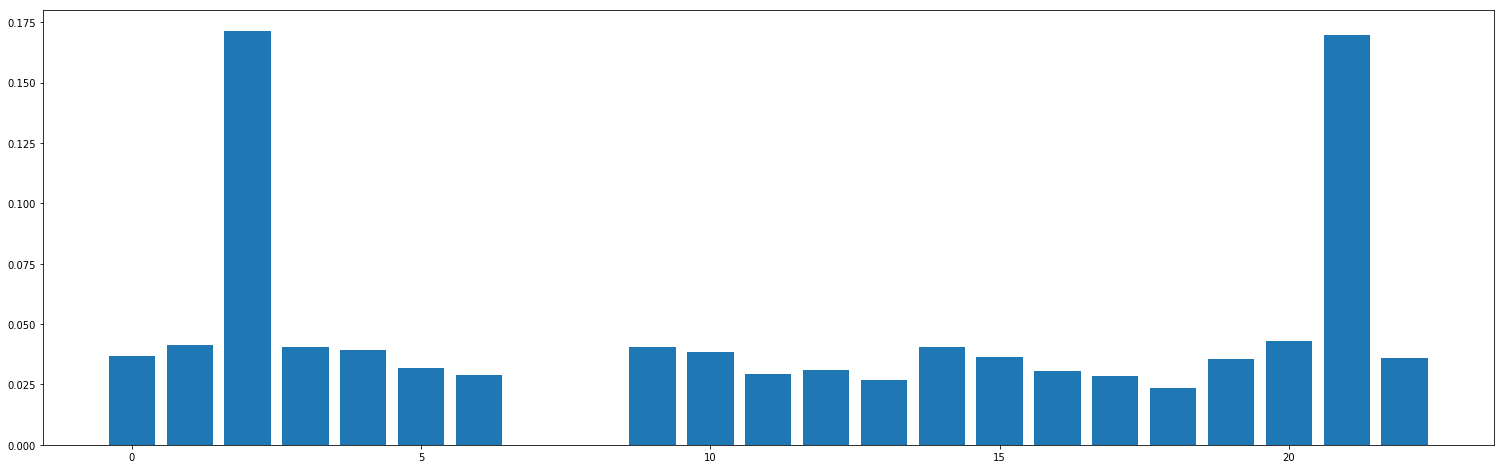

In [86]:
plt.figure(figsize=(26,8))
plt.bar(range(len(model_up.feature_importances_)), model_up.feature_importances_)
plt.show()

<Figure size 1872x1440 with 0 Axes>

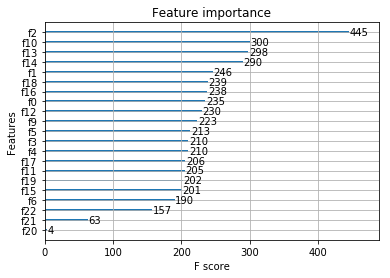

In [87]:
plt.figure(figsize=(26,20))
plot_importance(model_up)
plt.show()

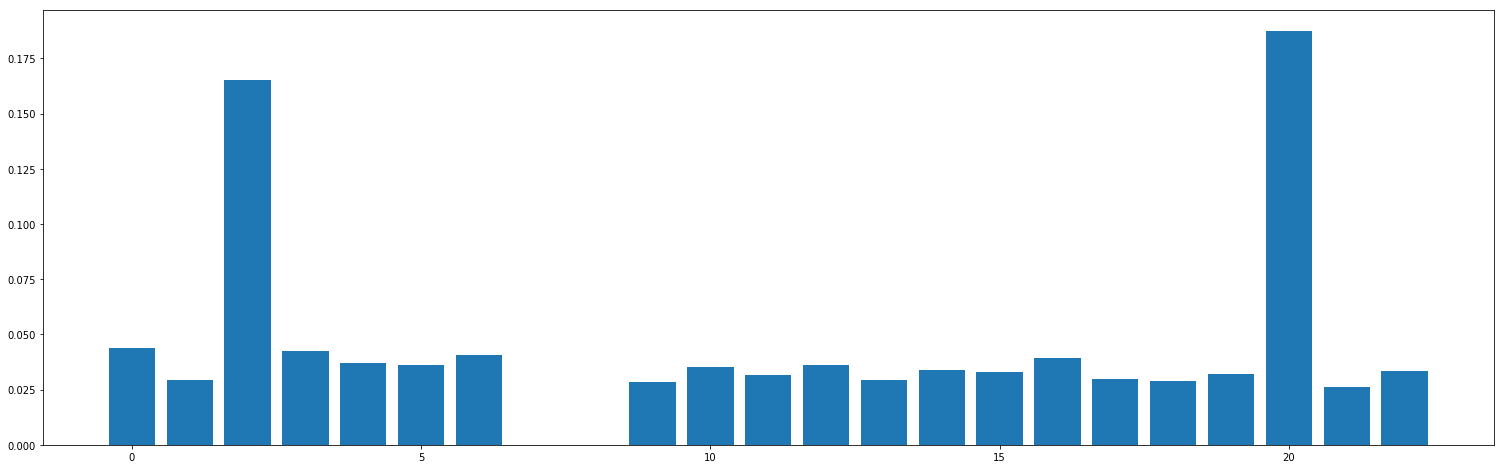

In [88]:
plt.figure(figsize=(26,8))
plt.bar(range(len(model_down.feature_importances_)), model_down.feature_importances_)
plt.show()

<Figure size 1872x1440 with 0 Axes>

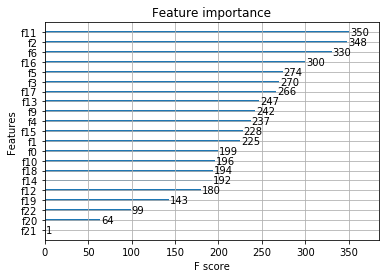

In [89]:
plt.figure(figsize=(26,20))
plot_importance(model_down)
plt.show()

In [90]:
from sklearn.feature_selection import SelectFromModel
print('Model up')
thresholds = np.sort(model_up.feature_importances_)
for thresh in range(0,len(thresholds)-1):
    selection = SelectFromModel(model_up, threshold=thresholds[thresh], prefit=True)
    select_Xtrain = selection.transform(Xtrain)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_Xtrain, ytrain_up)
	# eval model
    select_Xtest = selection.transform(Xtest)
    y_pred = selection_model.predict(select_Xtest)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(ytest_up, predictions)
    print('If n=',thresh,' accuracy ',round(accuracy*100),'%')

Model up
If n= 0  accuracy  78.0 %
If n= 1  accuracy  78.0 %
If n= 2  accuracy  78.0 %
If n= 3  accuracy  76.0 %
If n= 4  accuracy  76.0 %
If n= 5  accuracy  77.0 %
If n= 6  accuracy  74.0 %
If n= 7  accuracy  73.0 %
If n= 8  accuracy  76.0 %
If n= 9  accuracy  76.0 %
If n= 10  accuracy  76.0 %
If n= 11  accuracy  72.0 %
If n= 12  accuracy  74.0 %
If n= 13  accuracy  74.0 %
If n= 14  accuracy  75.0 %
If n= 15  accuracy  74.0 %
If n= 16  accuracy  74.0 %
If n= 17  accuracy  76.0 %
If n= 18  accuracy  76.0 %
If n= 19  accuracy  75.0 %
If n= 20  accuracy  75.0 %
If n= 21  accuracy  75.0 %


In [91]:
print('Model Down')
for thresh in range(0,len(thresholds)-1):
    selection = SelectFromModel(model_down, threshold=thresholds[thresh], prefit=True)
    select_Xtrain = selection.transform(Xtrain)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_Xtrain, ytrain_down)
	# eval model
    select_Xtest = selection.transform(Xtest)
    y_pred = selection_model.predict(select_Xtest)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(ytest_down, predictions)
    print('If n=',thresh,' accuracy ',round(accuracy*100),'%')

Model Down
If n= 0  accuracy  76.0 %
If n= 1  accuracy  76.0 %
If n= 2  accuracy  76.0 %
If n= 3  accuracy  76.0 %
If n= 4  accuracy  76.0 %
If n= 5  accuracy  76.0 %
If n= 6  accuracy  76.0 %
If n= 7  accuracy  75.0 %
If n= 8  accuracy  75.0 %
If n= 9  accuracy  74.0 %
If n= 10  accuracy  71.0 %
If n= 11  accuracy  73.0 %
If n= 12  accuracy  73.0 %
If n= 13  accuracy  73.0 %
If n= 14  accuracy  73.0 %
If n= 15  accuracy  73.0 %
If n= 16  accuracy  73.0 %
If n= 17  accuracy  73.0 %
If n= 18  accuracy  73.0 %
If n= 19  accuracy  73.0 %
If n= 20  accuracy  73.0 %
If n= 21  accuracy  80.0 %


In [92]:
yhat_up = model_up.predict(Xtest)
yhat_down = model_down.predict(Xtest)

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [93]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 77.59%
Precision: 54.55%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 31.58%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 61.71% 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       184
           1       0.55      0.32      0.40        57

   micro avg       0.78      0.78      0.78       241
   macro avg       0.68      0.62      0.63       241
weighted avg       0.75      0.78      0.75       241

[[169  15]
 [ 39  18]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [94]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 73.86%
Precision: 38.30%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 34.62%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 59.64% 
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       189
           1       0.38      0.35      0.36        52

   micro avg       0.74      0.74      0.74       241
   macro avg       0.60      0.60      0.60       241
weighted avg       0.73      0.74      0.73       241

[[160  29]
 [ 34  18]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [95]:
len(df_1D)-(len(df_1D)-241)

241

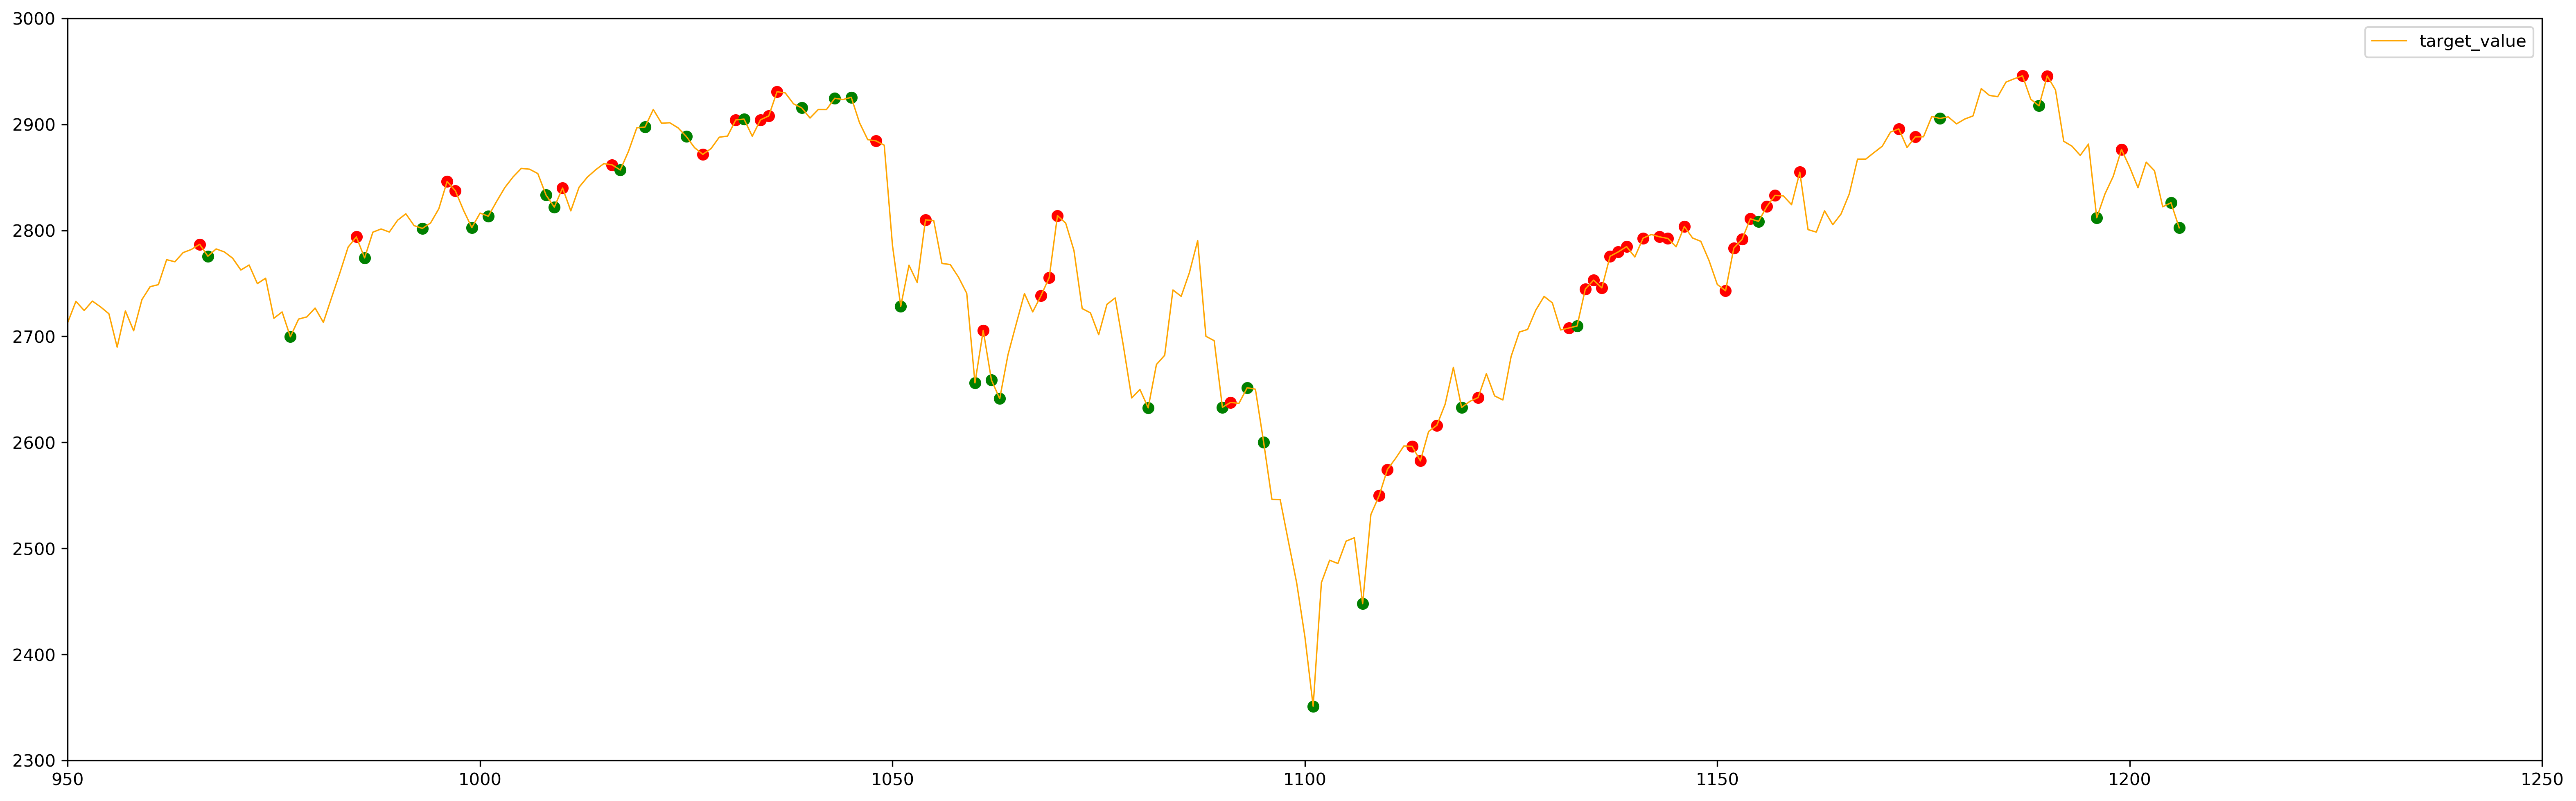

In [96]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1D['target_value'],color='orange',lw=0.8)
plt.xlim(950,1250)
plt.ylim(2300,3000)
a = -1
for i in range(len(df_1D)-241,len(df_1D)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='r',marker='o')
plt.legend()

In [97]:
sum(yhat_up),sum(yhat_down)

(33, 47)

In [98]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)